# Titanic: Machine Learning From Disaster

## 1. Importing Libraries and Data

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print(f'Number of training instances: {len(train_df)}')
print(f'Number of test instances: {len(test_df)}')

Number of training instances: 891
Number of test instances: 418


In [6]:
combined = train_df.append(test_df, sort=False).reset_index(drop=True)

In [7]:
combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# 2. Exploratory Data Anlaysis & Cleaning

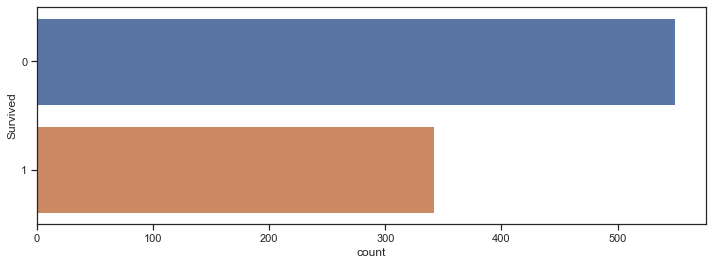

In [8]:
plt.figure(figsize=(12,4))
sns.countplot(y=train_df['Survived'])
plt.show()

In [9]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [10]:
combined.isnull().mean()

PassengerId    0.000000
Survived       0.319328
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
dtype: float64

We have to deal with some of these missing values (we can ignore the survived missing values because these are just from the test dataset). 20% of the Age values are missing so let's take a closer look at this data to see what the best way of approaching this is.

In [11]:
age_not_null = combined[~np.isnan(combined['Age'])]

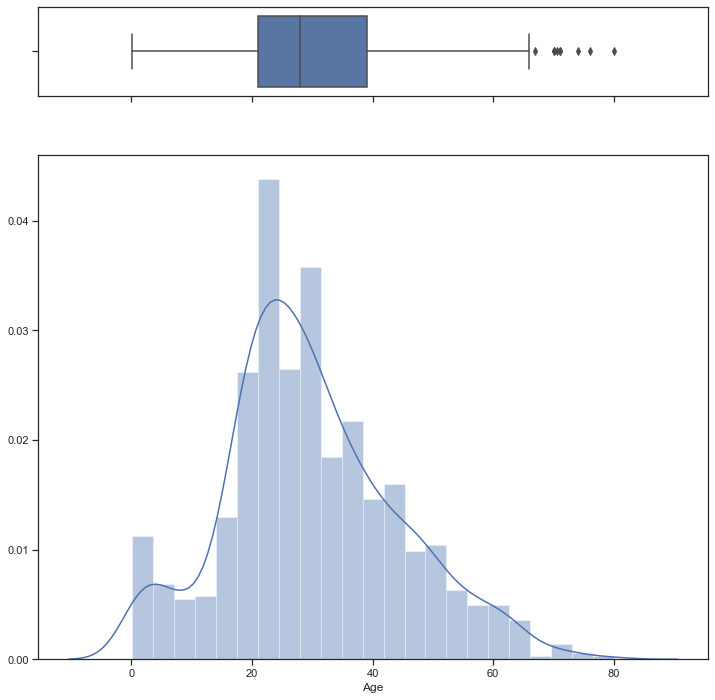

In [12]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
fig.set_size_inches(12,12)
sns.boxplot(age_not_null['Age'], ax=ax_box)
sns.distplot(age_not_null['Age'], ax=ax_hist)
ax_box.set_xlabel('')
plt.show()

The Age data is slightly positively skewed, but there aren't very many outliers, so we could fill in the missing age values with either the median or the mean age.

A better way of handling these values is going to be to group the data by some characteristics, i.e. Sex, Title or Pclass, or combinations of these and take the mean. This will likely result in a more accurate approximation for the missing values.

For this analysis we are going to group by Sex and Pclass. First let's see how the mean ages between these groups differ, and whether or not this will yield a better result than just simply filling NaNs with the mean or median of the entire dataset.

In [13]:
age_grouped = combined.copy()

In [14]:
age_grouped = age_grouped[['Age','Sex','Pclass']].groupby(by=['Sex','Pclass']).mean().round(1)

In [15]:
age_grouped

Age
Sex    Pclass      
female 1       37.0
       2       27.5
       3       22.2
male   1       41.0
       2       30.8
       3       26.0

In the dataframe above we can see that there are quite significant differences between the groups of passengers when split up by Sex and Pclass. Let's go ahead with filling in our NaNs for the Age feature with these values.

In [16]:
combined['Age'] = combined.groupby(by=['Sex','Pclass'], sort=False)['Age'].apply(lambda x: x.fillna(x.mean()))

In [17]:
combined.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Now we have one missing Fare value. Intuitively, Pclass will be the bes predictor of Fare, therefore we can fill in this value with the mean of the Pclass that that instance belongs to.

In [18]:
combined['Fare'] = combined.groupby(by=['Pclass'], sort=False)['Fare'].apply(lambda x: x.fillna(x.mean()))

Next we have the Cabin feature. 77% of these values are missing, therefore it's impossible for us to fill these NaNs with anything meaningful - we may just be adding more noise to our data and actually reducing our performance. Therefore we'll drop this feature entirely.

In [19]:
combined.drop(columns='Cabin', inplace=True)

Finally, there are two missing Embarked values. It's not obvious which features will be the best predictor of where the customer embarked the ship, so let's visualise this feature against some of the others to find out how we can handle these.

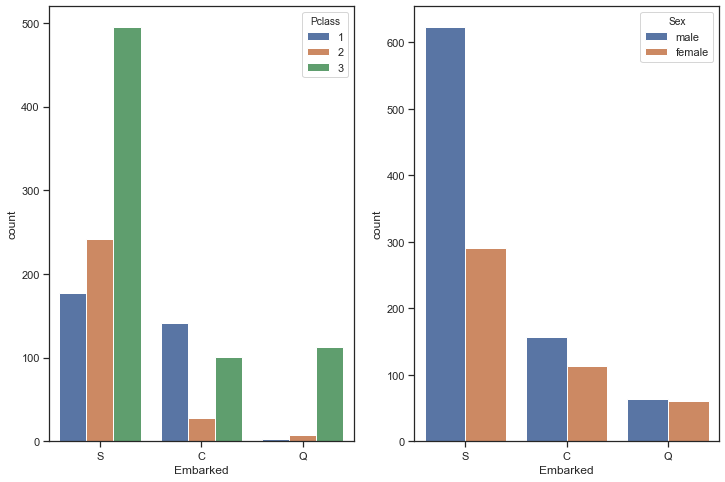

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.countplot('Embarked', data=combined, hue='Pclass')
plt.subplot(1,2,2)
sns.countplot('Embarked', data=combined, hue='Sex')
plt.show()

It's clear here that both Pclass and Sex can both help us with filling in these NaN values. If you're a in Pclass 3 and a man then you are more likely to be boarding at S! Since Embarked is a categorical variable, we can't just groupby and fill the NaN with the mean. The easiest was to do this is manually.

In [21]:
combined.loc[combined['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Both of these passengers are female and in Pclass 1, so they are most likely to have boarded at S.

In [22]:
combined['Embarked'] = combined['Embarked'].fillna('S')

In [23]:
combined.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

That's it, there are no NaN values left so we can move onto the next stage of the preprocessing.

The name column doesn't currently enrigh our dataset in any way at the moment, however if we extract the title out of the name then that will give us more information about the individual such as social and marital status.

In [24]:
combined['Title'] = combined['Name'].str.split().apply(lambda x: x[1])

In [25]:
combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,Mr.
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,Mrs.
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,Mrs.
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.962264,0,0,A.5. 3236,8.0500,S,Mr.
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C,y
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr.
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.962264,0,0,359309,8.0500,S,Mr.


In [26]:
combined['Title'].value_counts(normalize=False)

Mr.             736
Miss.           256
Mrs.            191
Master.          59
y                 8
Dr.               8
Rev.              8
Planke,           4
Col.              4
Impe,             3
Billiard,         3
Gordon,           2
Major.            2
Mlle.             2
Messemaeker,      2
Carlo,            2
Ms.               2
Cruyssen,         1
Pelsmaeker,       1
Velde,            1
Walle,            1
Brito,            1
Mme.              1
Steen,            1
Khalil,           1
Capt.             1
Don.              1
Jonkheer.         1
Palmquist,        1
der               1
Shawah,           1
the               1
Mulder,           1
Melkebeke,        1
Name: Title, dtype: int64

Everything after Master we will group into another category named 'Other'as there is very little representation from each of those groups so any models we use will unlikely be able to draw any statistically significant meaning from them.

In [27]:
combined['Title'] = combined['Title'].apply(lambda x: 'Other' if x not in ['Mr.','Miss.','Mrs.','Master.'] else x)

In [28]:
combined['Title'].value_counts(normalize=False)

Mr.        736
Miss.      256
Mrs.       191
Other       67
Master.     59
Name: Title, dtype: int64

As mentioned before, the Name feature isn't adding any more value to the dataset. Neither is Ticket in it's current form. The ticket number is not unique, groups travelling together share the same ticket, so coutning the number of people in that group could add some value, however any effect from this is also going to be somewhat capturesd by SibSp and Parch. Lastly, the PassengeId column is simply an index so we can also remove it from the dataset.

In [29]:
len(combined['Ticket'].unique())

929

In [30]:
combined.drop(columns=['Name','Ticket','PassengerId'], inplace=True)

## 3. Normalising and Encoding the Data

In [53]:
e_combined = combined.copy()

In [ ]:
cat_features = ['Pclass','Sex','Embarked','Title']

In [55]:
e_combined = pd.get_dummies(e_combined, columns=cat_features)

In [73]:
s_combined = combined.copy()

In [74]:
num_features = ['Age','SibSp','Parch','Fare']

In [75]:
scalar = StandardScaler()

In [78]:
ct = ColumnTransformer(
    [('num', scalar, num_features)], remainder='passthrough'
    )

In [79]:
s_combined = pd.DataFrame(ct.fit_transform(s_combined))

In [80]:
s_combined

,0,1,2,3,4,5,6,7,8
0,-0.560331,0.481288,-0.445,-0.503271,0,3,male,S,Mr.
1,0.655107,0.481288,-0.445,0.734756,1,1,female,C,Mrs.
2,-0.256471,-0.479087,-0.445,-0.49022,1,3,female,S,Miss.
3,0.427212,0.481288,-0.445,0.383198,1,1,female,S,Mrs.
4,0.427212,-0.479087,-0.445,-0.487804,0,3,male,S,Mr.
...,...,...,...,...,...,...,...,...,...
1304,-0.259338,-0.479087,-0.445,-0.487804,NaN,3,male,S,Mr.
1305,0.731072,-0.479087,-0.445,1.46204,NaN,1,female,C,Other
1306,0.693089,-0.479087,-0.445,-0.503271,NaN,3,male,S,Mr.
1307,-0.259338,-0.479087,-0.445,-0.487804,NaN,3,male,S,Mr.


In [31]:
train_df = combined.loc[:890]

In [32]:
test_df = combined.loc[891:].reset_index(drop=True)

In [34]:
train_df.to_csv('train_cleaned.csv')

In [35]:
test_df.to_csv('test_cleaned.csv')

## 4. Modelling

In [38]:
dtypes = {
    'Survived': 'int64',
    'Pclass': 'category',
    'Sex': 'category',
    'Age': 'float64',
    'SibSp': 'int',
    'Parch': 'int',
    'Fare': 'float',
    'Embarked': 'category',
    'Title': 'category'
}

In [40]:
train_df = pd.read_csv('train_cleaned.csv', dtype=dtypes)

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Unnamed: 0    891 non-null int64
Survived      891 non-null int64
Pclass        891 non-null category
Sex           891 non-null category
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null category
Title         891 non-null category
dtypes: category(4), float64(2), int64(4)
memory usage: 45.9 KB


In [42]:
train_df

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,0,3,male,22.000000,1,0,7.2500,S,Mr.
1,1,1,1,female,38.000000,1,0,71.2833,C,Mrs.
2,2,1,3,female,26.000000,0,0,7.9250,S,Miss.
3,3,1,1,female,35.000000,1,0,53.1000,S,Mrs.
4,4,0,3,male,35.000000,0,0,8.0500,S,Mr.
...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.000000,0,0,13.0000,S,Other
887,887,1,1,female,19.000000,0,0,30.0000,S,Miss.
888,888,0,3,female,22.185329,1,2,23.4500,S,Miss.
889,889,1,1,male,26.000000,0,0,30.0000,C,Mr.
